### Univariate time series analysis with ARIMA and SARIMA

<p style="text-align: justify">In this notebook, we conduct a univariate time series analysis on cryptocurrency data. The coin chosen is <a href="https://en.wikipedia.org/wiki/Ripple_(payment_protocol)">XRP</a> as it is one of the most popular cryptocurrency which recently got the 2nd position in terms of market capitalization, and which also has great potential in the future, in terms of payment and transaction speed. Indeed, XRP is often referenced as the "bankers coin" as institutions and banks have been partnering with Ripple for their different transaction enhancing procedures. 

<p style="text-align: justify">The historical data of the coin has been harvested on the web using the <a href="https://www.crummy.com/software/BeautifulSoup/">Beautiful Soup</a> library and saved in <em>csv</em> format, but this is not the purpose of this notebook. In case the reader is interested in this procedure, he can visit my <a href="https://github.com/DavidCico/Web-scraping-with-Beautiful-Soup-an-example-on-cryptocurrency-data">GitHub repository</a> on that matter.</p>

<p style="text-align: justify">The <b>"XRP_price"</b> dataset is a multivariate time series dataset that describes the historical price of the coin from almost its debut as exchange currency. The data goes from August 2013 to December 2018, with daily observations of the different quantities. It is a multivariate series comprised of 3 variables (besides the date and time); they are:</p>

<ul>
<li><strong>Close XRP</strong>: The daily closing price of the cryptocurrency (\$USD).</li>
<li><strong>Volume XRP</strong>: The total daily volume of the coin (\$USD).</li>
<li><strong>Market Cap</strong>: The total daily market capitalization of the coin (\$USD).</li>
</ul>




In [1]:
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
from warnings import catch_warnings
from warnings import filterwarnings

# for parallel computing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

ModuleNotFoundError: No module named 'joblib'

<p align="justify">After importing the different libraries that will be used in the code, we can use the <em>read_csv()</em> function to load the data and infer the first column containing the date data as an index.</p>

```python
dataset = pd.read_csv(name_coin + '_price.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
```

In [8]:
# Write name of coin for study (XRP, BTC)
name_coin = 'XRP'

dataset = pd.read_csv(name_coin + '_price.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

# fill all NaN values with some particular value
dataset.fillna(0, inplace=True)

# look at the values of the dataset
values = dataset.values

# Counting number of days per year
count_yearly_days =dataset['Close ' + name_coin].resample("Y").count()
print(count_yearly_days)

# print dataset stats
print(dataset.describe())


# definition of a series from the values of the dataframe
series = pd.Series(values[:,0])
series.index = dataset.index
series.index.name = 'date'

Date
2013-12-31    149
2014-12-31    365
2015-12-31    365
2016-12-31    366
2017-12-31    365
2018-12-31    350
Freq: A-DEC, Name: Close XRP, dtype: int64
         Close XRP    Volume XRP  Market Cap XRP
count  1960.000000  1.960000e+03    1.960000e+03
mean      0.164995  2.000525e+08    6.352882e+09
std       0.341782  6.846502e+08    1.334716e+10
min       0.002810  0.000000e+00    2.196991e+07
25%       0.006315  2.744888e+05    1.735673e+08
50%       0.008615  9.076330e+05    2.580457e+08
75%       0.211142  1.335985e+08    8.117047e+09
max       3.380000  9.110440e+09    1.308535e+11


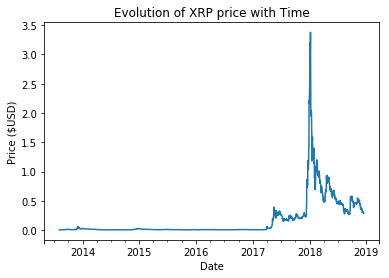

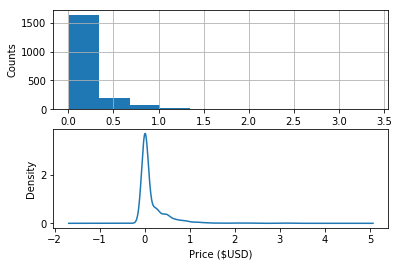

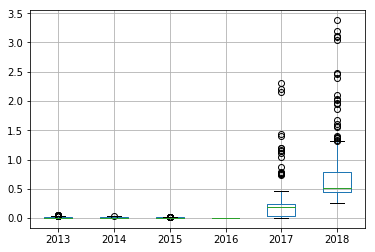

In [3]:
# plot the series against time
series.plot()
plt.ylabel('Price ($USD)')
plt.xlabel('Date')
plt.title('Evolution of XRP price with Time')
plt.show()

# density plot
plt.figure()
plt.subplot(211)
plt.xlabel('Price ($USD)')
plt.ylabel('Counts')
series.hist()
plt.subplot(212)
plt.xlabel('Price ($USD)')
series.plot(kind='kde')
plt.show()

# Box and Whisker plots
groups = series['2013':'2018'].groupby(pd.Grouper(freq='Y'))

years_df = list()
for name, group in groups:
    df = pd.DataFrame()
    df[name.year] = group.values
    years_df.append(df)
# concatenate the columns of the different coins and save the dataset to a csv file
years = pd.concat(years_df, axis = 1, sort=False)
#print(years.head(20))
years.boxplot()
plt.show()

In [4]:
# check if stationary
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.122826
p-value: 0.024909
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


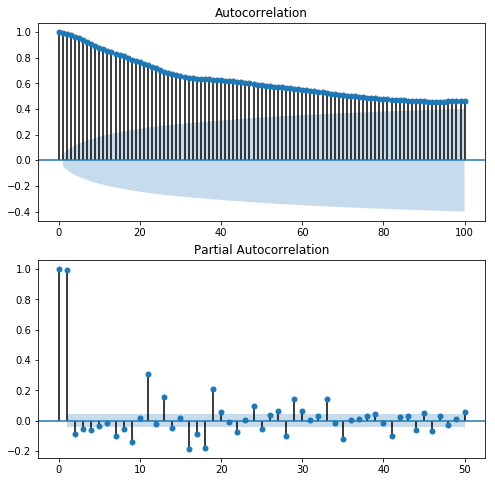

In [5]:
# plot Autocorrelation and Partial ACF plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8,8))
plot_acf(series, lags =100, ax = ax1)
plot_pacf(series, lags =50, ax = ax2)
plt.show()

### Evaluation metric

<p>A forecast will be comprised of seven values, one for each day of the week ahead.</p>
<p align="justify">It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:</p>
<ul>
<li>To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).</li>
<li>To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).</li>
</ul>
<p align="justify">Both <a href="https://en.wikipedia.org/wiki/Root-mean-square_deviation">Root Mean Squared Error (RMSE)</a> and <a href="https://en.wikipedia.org/wiki/Mean_absolute_error">Mean Absolute Error (MAE)</a> can be used to quantify the errors in price prediction (USD), although RMSE is more commonly used and will be adopted in this notebook. Unlike MAE, RMSE is more punishing of forecast errors.</p>
<p align="justify">The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7. In this way, we can see how the chosen algorithms perform on the predictions at a particular day of the week. The cryptocurrency market is quite volatile, and may have a different behaviour depending on the period of the week (weekdays or weekend for instance).</p>
<p align="justify">As a short-cut, it may be useful to summarize the performance of a model using a single score in order to help in model selection. One possible score that could be used would be the RMSE across all forecast days.</p>

<p align="justify">The function <i>evaluate_forecasts()</i> below will implement this behavior and return the performance of a model based on multiple seven-day forecasts.</p>


In [7]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores